# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [155]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
random.seed(0)
from sklearn.utils.validation import check_random_state
check_random_state(0)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
### Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sample_indices = random.sample(range(len(features)), 20000)
features1, labels1 = features.iloc[sample_indices], labels.iloc[sample_indices]

X_train, X_test, y_train, y_test = train_test_split(features1, labels1, test_size=0.2, random_state=0)
# scaler = StandardScaler()
# scaler.fit(X_train)
X_train = pd.DataFrame(columns= X_train.columns, data= X_train, index = X_train.index)
X_test = pd.DataFrame(columns= X_test.columns, data = X_test, index= X_test.index)
X_train = X_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

### Create one classifier to predict income on RAW DATA
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbc.fit(X_train, y_train)

### Report general accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve
from sklearn.model_selection import cross_val_score

probs = gbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
preds = accuracy_score(y_test, probs > 0.5)

print('Scores across all groups.')
print('AUC: ', auc(fpr, tpr))
print('Accuracy: ', preds)
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', gbc)])
print('Overall cross val score: ', cross_val_score(pipe , X_train, y_train).mean())
print('---------------------------')

### report accuracy for gender groups and races
accuracies_female, accuracies_nonfemale = [], []
accuracies_black, accuracies_nonblack = [], []
for j in [0, 4000, 8000, 12000]:
    test = list(range(j, j+4000))
    X_test_temp = X_train.iloc[test]
    y_test_temp = y_train.iloc[test]
    X_train_temp = X_train.drop(test)
    y_train_temp = y_train.drop(test)
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', gbc)])
    pipe.fit(X_train_temp, y_train_temp)
    for i in set(X_train['RAC1P_Black or African American alone']):
        X_test_temp_group = X_test_temp[X_test_temp['RAC1P_Black or African American alone'] == i]
        y_test_temp_group = y_test_temp.loc[X_test_temp_group.index]
        temp_preds = pipe.predict(X_test_temp_group)
        accuracy = accuracy_score(y_test_temp_group, temp_preds)
        if i > 0:
            accuracies_black.append(accuracy)
        else:
            accuracies_nonblack.append(accuracy)
    for i in set(X_train['SEX_Female']):
        X_test_temp_group = X_test_temp[X_test_temp['SEX_Female'] == i]
        y_test_temp_group = y_test_temp.loc[X_test_temp_group.index]
        temp_preds = pipe.predict(X_test_temp_group)
        accuracy = accuracy_score(y_test_temp_group, temp_preds)
        if i > 0:
            accuracies_female.append(accuracy)
        else:
            accuracies_nonfemale.append(accuracy)

print(f'Accuracy for Black: {np.mean(accuracies_black)}')
print(f'Accuracy for Non-Black: {np.mean(accuracies_nonblack)}')
print(f'Accuracy for Female: {np.mean(accuracies_female)}')
print(f'Accuracy for Non-Female: {np.mean(accuracies_nonfemale)}')

Scores across all groups.
AUC:  0.8731786669584526
Accuracy:  0.82925
Overall cross val score:  0.8318125000000001
---------------------------
Accuracy for Black: 0.7986253369329681
Accuracy for Non-Black: 0.8351035673728491
Accuracy for Female: 0.8089415761132231
Accuracy for Non-Female: 0.8535120289558584


In [157]:
accuracies_black, accuracies_nonblack = [], []

for j in [0, 4000, 8000, 12000]:
    test = list(range(j, j+4000))
    X_test_temp = X_train.iloc[test]
    y_test_temp = y_train.iloc[test]
    X_train_temp = X_train.drop(test)
    y_train_temp = y_train.drop(test)
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', gbc)])
    pipe.fit(X_train_temp, y_train_temp)
    for i in set(X_train['RAC1P_Black or African American alone']):
        X_test_temp_group = X_test_temp[X_test_temp['RAC1P_Black or African American alone'] == i]
        y_test_temp_group = y_test_temp.loc[X_test_temp_group.index]
        temp_preds = pipe.predict(X_test_temp_group)
        accuracy = accuracy_score(y_test_temp_group, temp_preds)
        if i > 0:
            accuracies_black.append(accuracy)
        else:
            accuracies_nonblack.append(accuracy)

In [158]:
print(features['RAC1P_Black or African American alone'].value_counts()/len(features))
print(features1['RAC1P_Black or African American alone'].value_counts()/len(features1))
print(features['SEX_Female'].value_counts()/len(features))
print(features1['SEX_Female'].value_counts()/len(features1))

0.0    0.933955
1.0    0.066045
Name: RAC1P_Black or African American alone, dtype: float64
0.0    0.9327
1.0    0.0673
Name: RAC1P_Black or African American alone, dtype: float64
0.0    0.532536
1.0    0.467464
Name: SEX_Female, dtype: float64
0.0    0.5329
1.0    0.4671
Name: SEX_Female, dtype: float64


In [159]:
scaler = StandardScaler()
X_train = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
Xs_train_p = X_train.values[:, 54:]
Xs_test_p = X_test.values[:, 54:]
Xs_train_np = X_train.values[:, :54]
Xs_test_np = X_test.values[:, :54]

In [170]:
# ### Create a fairer version of the dataset to protect select groups
# protected_cols = ['RAC1P_Black or African American alone','SEX_Female']
# X_train_unprotected, X_train_protected = X_train.drop(columns = protected_cols), X_train[protected_cols]
# X_test_unprotected, X_test_protected = X_test.drop(columns = protected_cols), X_test[protected_cols]

def debias_features(Xs_np, Xs_p, lambda_param=0.7):
    import scipy
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = scipy.linalg.orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np - lambda_param * (orthbasis @ orthbasis.T @ Xs_np)

    # Return debiased nonprotected features
    return Xs_np_debiased


accuracies_all = []
accuracies_sex_1 = []
accuracies_sex_2 = []
accuracies_race_1 = []
accuracies_race_2 = []
protected_cols = ['RAC1P_Black or African American alone', 'SEX_Female']
pipe = Pipeline(steps=[('classifier', gbc)])

for idx, i in enumerate([0.1, 1/3, 0.5, 2/3, 1, 2, 3, 4]):
    X_train_unprotected_debiased = debias_features(Xs_train_np, Xs_train_p, i)
    X_train_debiased = np.concatenate([X_train_unprotected_debiased, Xs_train_p], axis=1)
    # Compute correlation matrix
    n_features = X_train.shape[1]
    corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(n_features):
            corr_[i,j], p_[i,j] = pearsonr(X_train_debiased[:,i], X_train_debiased[:,j])
            corr_ = np.nan_to_num(corr_, 0)

    # Plot correlations with protected features
    # plt.figure(idx, figsize=(4,15))
    # sns.heatmap(corr_[:,54:], cmap="bwr", xticklabels=features.columns[54:], yticklabels=features.columns, vmin=-1, vmax=1)
    # plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
    # plt.show()
    # Train a classifier on the debiased data for each group
    pipe.fit(X_train_debiased, y_train)
    preds = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    accuracies_all.append(accuracy)
    X_test_women = X_test[X_test['SEX_Female'] > 0]
    X_test_men = X_test[X_test['SEX_Female'] < 0]
    y_test_men = y_test.loc[X_test_men.index]
    y_test_women = y_test.loc[X_test_women.index]
    X_test_black = X_test[X_test['RAC1P_Black or African American alone'] > 0]
    X_test_non_black = X_test[X_test['RAC1P_Black or African American alone'] < 0]
    y_test_black = y_test.loc[X_test_black.index]
    y_test_non_black = y_test.loc[X_test_non_black.index]
    accuracies_race_1.append(accuracy_score(y_test_black, pipe.predict(X_test_black)))
    accuracies_race_2.append(accuracy_score(y_test_non_black, pipe.predict(X_test_non_black)))
    accuracies_sex_1.append(accuracy_score(y_test_women, pipe.predict(X_test_women)))
    accuracies_sex_2.append(accuracy_score(y_test_men, pipe.predict(X_test_men)))

In [171]:
stats = pd.DataFrame()
stats.index = [0.1, 1/3, 0.5, 2/3, 1, 2, 3, 4]
stats['All'] = accuracies_all
stats['Women'] = accuracies_sex_1
stats['Men'] = accuracies_sex_2
stats['Black'] = accuracies_race_1
stats['Non-Black'] = accuracies_race_2

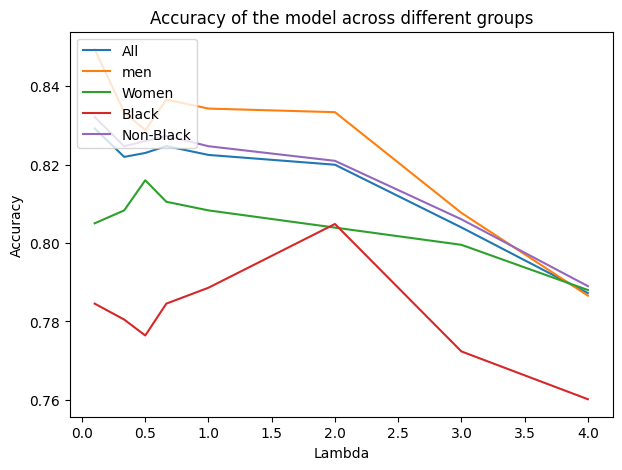

In [172]:
### Build model using de-correlation effect from https://dl.acm.org/doi/10.1145/3375627.3375864
plt.figure(figsize=(7, 5))
sns.lineplot(data=stats, x = stats.index, y = stats['All'], label = 'All', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Men', label = 'men', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Women', label = 'Women', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Black', label = 'Black', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Non-Black', label = 'Non-Black', markers=True)
plt.title("Accuracy of the model across different groups")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
# move legend to upper left 
plt.legend(loc='upper left')
plt.show()

# Task 2.2 - FairPCA

## Reprojecting data using FairPCA implementation from exercise 7 solution

In [163]:
import scipy

In [164]:
class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        # Extract protected features
        Xs_p = Xs[:, p_idxs]

        # Compute projection matrix (U)
        Z = Xs_p
        #Z = Z - Z.mean(0) # Since we alredy standardised everything, there is not much sense in removing the mean
        R = scipy.linalg.null_space(Z.T @ Xs)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        return Xs @ self.U
    
fair_pca = FairPCA(X_train.to_numpy(), [54, 55], 30)
Xs_train_debiased = fair_pca.project(X_train)
Xs_test_debiased = fair_pca.project(X_test)

In [165]:
# Compute correlation matrix
Xs_train_debiased_p = np.concatenate([Xs_train_debiased, Xs_train_p], axis=1)
n_features = Xs_train_debiased_p.shape[1]
corr_ = np.zeros((n_features, n_features))
p_ = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_[i,j], p_[i,j] = pearsonr(Xs_train_debiased_p[:,i], Xs_train_debiased_p[:,j])
        corr_ = np.nan_to_num(corr_, 0)

# Plot correlations with protected features
# plt.figure(figsize=(4,15))
# sns.heatmap(corr_[:,-2:], cmap="coolwarm", xticklabels=features.columns[-2:], vmin=-1, vmax=1)
# plt.title("Pearson's Correlation Coeff between SEX and components (Masked by p value)")
# plt.show()

## Building classification model with reprojected data from FairPCA

In [166]:
# Adapted from previous code, some fuckery had to happen

# convert to pandas DataFrames
Xs_train_debiased_p_df = pd.DataFrame(data=Xs_train_debiased_p)
Xs_test_debiased_p = np.concatenate([Xs_test_debiased, Xs_test_p], axis=1)
Xs_test_debiased_p_df = pd.DataFrame(data=Xs_test_debiased_p)

# overall accuracy
gbc.fit(Xs_train_debiased_p_df.drop([30, 31], axis=1), y_train)
probs = gbc.predict_proba(Xs_test_debiased_p_df.drop([30, 31], axis=1))[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
accuracy = accuracy_score(y_test, probs > 0.5)
print(f'Overall accuracy:   {accuracy}')

# accuracy for the groups
Xs_test_debiased_women = Xs_test_debiased_p_df[Xs_test_debiased_p_df[30] > 0]
Xs_test_debiased_men = Xs_test_debiased_p_df[Xs_test_debiased_p_df[30] < 0]
y_test_men = y_test.iloc[Xs_test_debiased_men.index]
y_test_women = y_test.iloc[Xs_test_debiased_women.index]
Xs_test_debiased_black = Xs_test_debiased_p_df[Xs_test_debiased_p_df[31] > 0]
Xs_test_debiased_non_black = Xs_test_debiased_p_df[Xs_test_debiased_p_df[31] < 0]
y_test_black = y_test.iloc[Xs_test_debiased_black.index]
y_test_non_black = y_test.iloc[Xs_test_debiased_non_black.index]
print(f'Accuracy Black:     {accuracy_score(y_test_black, gbc.predict(Xs_test_debiased_black.drop([30, 31], axis=1)))}')
print(f'Accuracy Non-Black: {accuracy_score(y_test_non_black, gbc.predict(Xs_test_debiased_non_black.drop([30, 31], axis=1)))}')
print(f'Accuracy Women:     {accuracy_score(y_test_women, gbc.predict(Xs_test_debiased_women.drop([30, 31], axis=1)))}')
print(f'Accuracy Men:       {accuracy_score(y_test_men, gbc.predict(Xs_test_debiased_men.drop([30, 31], axis=1)))}')

Overall accuracy:   0.8155
Accuracy Black:     0.7764227642276422
Accuracy Non-Black: 0.8180607352157698
Accuracy Women:     0.7935200439319056
Accuracy Men:       0.8338687471317118
